In [ ]:
# 列出根目录（确认挂载成功）
!ls /content/drive/My\ Drive
# 列出作业路径
!ls /content/drive/My\ Drive/cs231n/assignment/
!ls /content/drive/My\ Drive/cs231n/assignment/assignment1/


'Colab Notebooks'   cs231n  'Google 地球'
assignment1  test
collect_submission.ipynb  features.ipynb	    makepdf.py
collectSubmission.sh	  FullyConnectedNets.ipynb  softmax.ipynb
cs231n			  knn.ipynb		    two_layer_net.ipynb


In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignment/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignment/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignment/assignment1


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [ ]:
# Run some setup code for this notebook.
# 为本笔记本运行一些设置代码。

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
# 这是一个小技巧，可以使 matplotlib 图形以内联方式显示在笔记本中
# 而不是在新窗口中显示。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# 更神奇的是，笔记本会重新加载外部 python 模块；
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
# 清理变量以防止多次加载数据（可能导致内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
# 作为正确性检查，我们会打印出训练数据和测试数据的大小。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


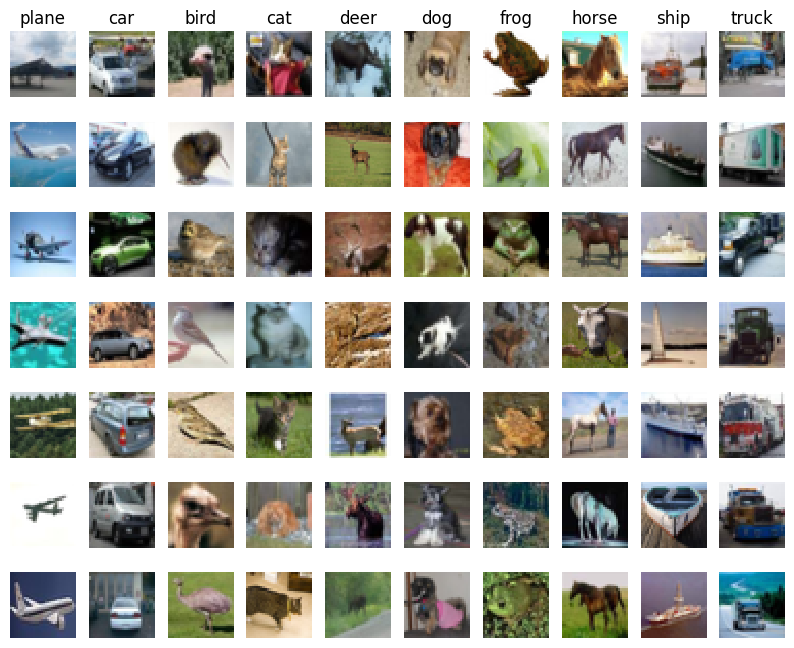

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# 可视化数据集中的一些示例。
# 我们展示每个类别中的一些训练图像示例。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
# 对数据进行抽样，以便在本练习中更高效地执行代码
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
# 将图像数据重塑为行向量
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
# 创建一个 kNN 分类器实例。
# 记住，kNN 分类器的训练是无用的：
# 分类器只需记住数据，不做进一步处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

现在，我们想用 kNN 分类器对测试数据进行分类。回想一下，我们可以将这一过程分为两个步骤：

1. First we must compute the distances between all test examples and all train examples 首先，我们必须计算所有测试示例和所有训练示例之间的距离。
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label 给定这些距离后，我们会为每个测试示例找到 k 个最近的示例，并让它们为标签投票

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

我们先计算所有训练示例和测试示例之间的距离矩阵。例如，如果有 Ntr 个训练示例和 Nte 个测试示例，这一阶段就会得到一个 Nte x Ntr 矩阵，其中每个元素 (i,j) 都是第 i 个测试示例和第 j 个训练示例之间的距离。

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

**注意：对于我们要求您在本笔记本中实现的三种距离计算，您可以不使用 numpy 提供的 np.linalg.norm() 函数。**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

首先，打开 cs231n/classifiers/k_nearest_neighbor.py，并实现函数 compute_distances_two_loops，该函数使用（非常低效的）双循环遍历所有（测试、训练）示例对，每次计算一个元素的距离矩阵。


In [ ]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.
# 在左侧"文件"中打开 cs231n/classifiers/k_nearest_neighbor.py，并执行
# compute_distances_two_loops。

# Test your implementation:
# 测试你的实现：
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


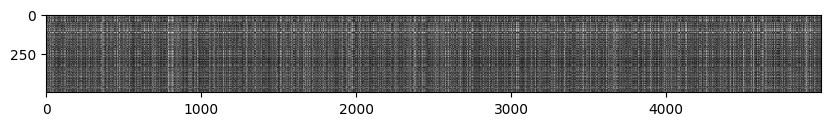

In [ ]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
# 我们可以直观地看到距离矩阵：每一行是一个测试示例，以及它与训练示例的距离。
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *fill this in.*

**小问题1**

请注意距离矩阵中的结构模式，其中某些行或列明显较亮。(请注意，在默认配色方案中，黑色表示低距离，白色表示高距离）。

- 数据中是什么原因导致行明显变亮？
- 是什么原因导致了这些列？

在这里填写你的回答：

行亮说明这张测试图与训练集距离较远，和谁都不像，可能说明测试图质量低，也可能说明训练集选的不好，要根据具体情况而定

列亮说明这张训练图与测试集的拟合效果不好，可能本身是贡献较小的怪异图

In [ ]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
# 现在执行函数 predict_labels，并运行下面的代码：
# 我们使用 k = 1（即最近邻）。
# 注意仍旧是打开knn.py后编写相应函数
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
# 计算并打印正确预测示例的比例
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

确实轻微

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

**小问题2**

我们还可以使用其他距离度量，如 L1 距离。
对于某个图像 $I_k$ 的位置 $(i,j)$上的像素值 $p_{ij}^{(k)}$、

所有图像中所有像素的平均值 $\mu$ 是

$$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$

而所有图像的像素平均值 $\mu_{ij}$ 是

$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}. $$

一般标准偏差 $\sigma$ 和像素标准偏差

以下哪些预处理步骤不会改变使用 L1 距离的近邻分类器的性能？请选择所有适用的步骤。说明一下，训练和测试示例的预处理方式相同。

1. 减去平均值 $\mu$ （$\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$。）
2. 减去每个像素的平均值 $\mu_{ij}$ （$\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$）。
3. 减去平均值 $\mu$，除以标准偏差 $\sigma$。
4. 减去像素平均值 $\mu_{ij}$，再除以像素标准偏差 $\sigma_{ij}$。
5. 旋转数据的坐标轴，也就是将所有图像旋转相同的角度。由旋转引起的图像中的空白区域将用相同的像素值填充，不执行插值。

你的回答：

1和3

你的解释：

L1距离的等值轮廓为一个菱形，不像L2距离的圆形，一般在自变量与因变量之间的关系较为清晰（大致明确各自变量对因变量的影响）时采用L1距离来刻画关系，因而平移、按比例缩放等操作不会影响样本间的相对距离，而对每个像素不同的处理或对整张图像进行旋转、裁剪甚至非线性变化都会影响相对距离

1减去一个常数仅相当于图像平移，2则是一种居中到0附近的平滑化操作，3是全局归一化相当于先平移再整体缩放，4是重新加权每一维度的操作，而5是典型的旋转，因而选择1和3

In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
# 现在，让我们通过部分矢量化来加快距离矩阵的计算速度
# 只需一个循环。执行 compute_distances_one_loop 函数并运行
# 代码：
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
# 为了确保我们的矢量化实现是正确的，我们要确保它与朴素实现一致。
# 判断两个矩阵是否相似；最简单的方法之一是弗罗贝尼斯规范。
# 以防你之前没有见过，两个矩阵的弗罗贝尼斯规范是两个矩阵的所有元素差值平方和的平方根
# 换句话说，将两个矩阵重塑为向量，然后计算它们之间的欧氏距离。
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 42.807713 seconds
One loop version took 41.263253 seconds
No loop version took 0.629483 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

我们已经实现了kNN分类器，但随意设置了k=5。现在我们将通过交叉验证来确定该超参数的最佳值。

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                        #
# Split up the training data into folds. After splitting, X_train_folds and #
# y_train_folds should each be lists of length num_folds, where        #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].  #
# Hint: Look up the numpy array_split function.                 #
# TODO：                                        #
# 将训练数据拆分成多个折叠。拆分后，X_train_folds和y_train_folds都应该是长度为num_folds的列表 #
# 其中y_train_folds[i]是X_train_folds[i]中点的标签向量。 #
# 提示：查找 numpy array_split 函数。                #
################################################################################

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                             #
# Perform k-fold cross validation to find the best value of k. For each       #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,      #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                     #
# 进行k倍交叉验证，找出k的最佳值。对于每个可能的k值，运行kNN算法 num_folds 次，        #
# 在每种情况下，除了一个折叠数据外，其他所有折叠数据都用作训练数据，最后一折用作验证集     #
# 最后一折作为验证集。将所有折的准确率和所有k值存入k_to_accuracies               #
################################################################################

for k in k_choices:
    k_to_accuracies[k] = []

    for i in range(num_folds):
        # 准备验证集
        X_val = X_train_folds[i]
        y_val = y_train_folds[i]

        # 合并剩下的折作为训练集
        X_train_cv = np.vstack(X_train_folds[:i] + X_train_folds[i+1:])
        y_train_cv = np.hstack(y_train_folds[:i] + y_train_folds[i+1:])

        # 训练模型（注意这时用的是训练子集）
        classifier = KNearestNeighbor()
        classifier.train(X_train_cv, y_train_cv)

        # 计算距离 & 预测
        dists = classifier.compute_distances_no_loops(X_val)
        y_val_pred = classifier.predict_labels(dists, k=k)

        # 计算准确率
        accuracy = np.mean(y_val_pred == y_val)
        k_to_accuracies[k].append(accuracy)


# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

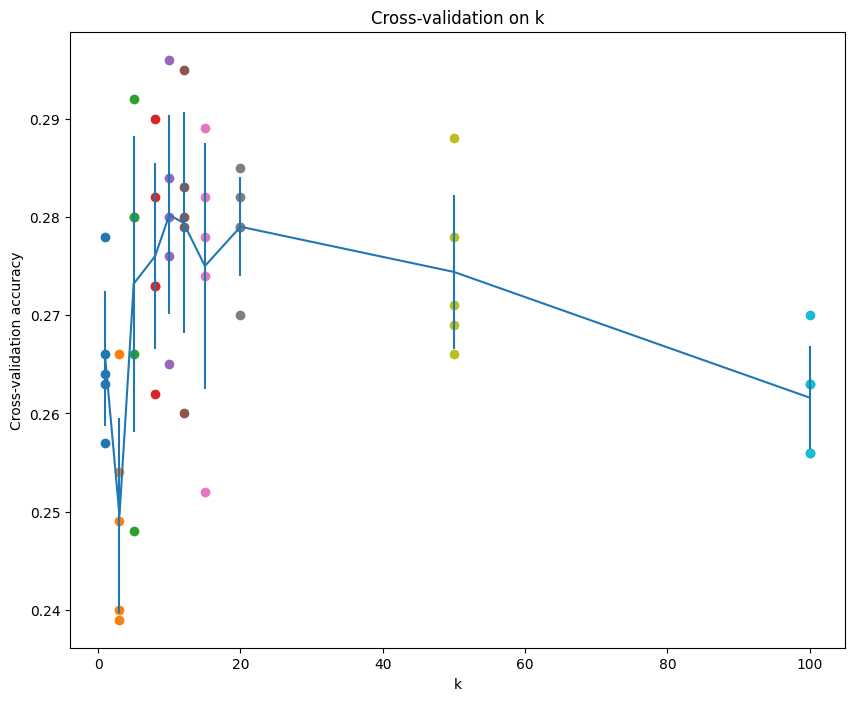

In [ ]:
# plot the raw observations
# 绘制原始观测数据
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
# 绘制趋势线，误差条与标准偏差相对应
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
# 根据上述交叉验证结果，为 k 选择最佳值、
# 使用所有训练数据重新训练分类器，并在测试数据上进行测试
# 数据。你应该能在测试数据上获得 28% 以上的准确率。
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$

**小问题3**

在分类设置中，对于所有 $k$，以下哪些关于 $k$ 近邻（$k$-NN）的说法是正确的？请选择所有适用的选项。

1. k-NN 分类器的决策边界是线性的。
2. 1-NN 的训练误差总是低于或等于 5-NN 的误差。
3. 1-NN 的测试误差总是低于 5-NN 的测试误差。
4. 使用 k-NN 分类器对测试示例进行分类所需的时间随训练集的大小而增长。
5. 以上都不是。

你的回答：

2和4

你的解释：

1错，kNN的决策边界是高度非线性的

2对，1NN在训练集上总能正确分类自身，因此训练误差为0。k越大时分类结果更平滑，训练误差可能增加

3错，1NN更容易过拟合，在测试集上反而可能误判，5NN通过投票更鲁棒，测试误差未必更大

4对，kNN在分类时需要对每个测试样本与所有训练样本计算距离，训练集越大，分类越慢

